In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

In [4]:
import re
import string

In [5]:
import joblib
import json

In [6]:
def limpia_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'\d+', '', texto) # números
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # signos de puntuación
    texto = re.sub(r'\s+', ' ', texto).strip() # espacios
    return ' '.join([p for p in texto.split() if p.isalpha()])

In [7]:
def evaluacion(y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Reporte de clasificación del modelo optimizado: {classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo'])}")
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Purples", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Predicciones')
    plt.title('Matriz de Confusión')
    plt.show()

In [8]:
df = pd.read_csv("./dataset/df_completo.csv")

In [9]:
df['texto_limpio'] = df["text"].apply(limpia_texto)

In [10]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['texto_limpio'])
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.3, random_state=42)

In [11]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(X)

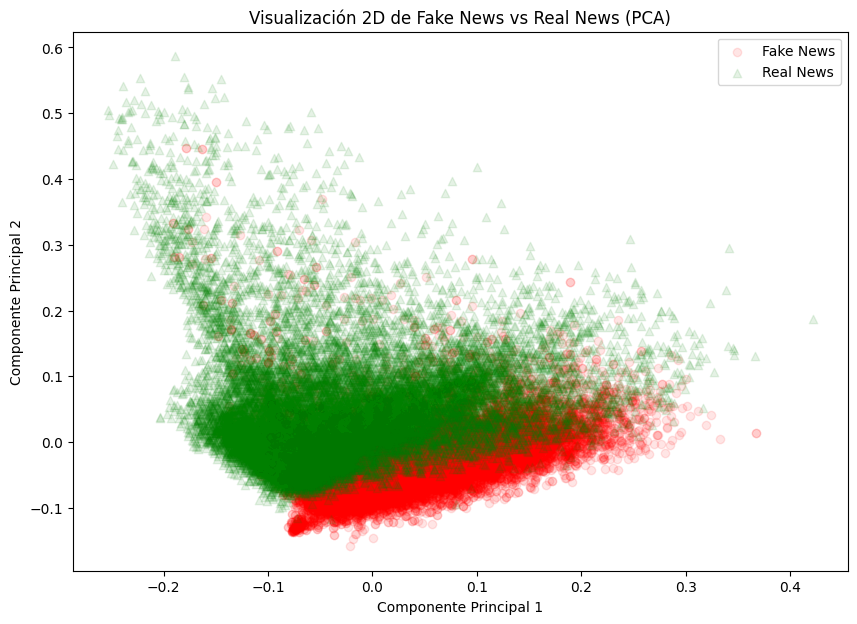

In [12]:
# 2D
plt.figure(figsize=(10, 7))
plt.scatter(pca_embeddings[df["label"] == 0, 0], pca_embeddings[df["label"] == 0, 1], c='red', marker='o', label="Fake News", alpha=0.1)
plt.scatter(pca_embeddings[df["label"] == 1, 0], pca_embeddings[df["label"] == 1, 1], c='green', marker='^', label="Real News", alpha=0.1)
plt.title("Visualización 2D de Fake News vs Real News (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()

In [13]:
modelo = SVC(random_state=42, 
             probability=True) # confianza de la predicción

In [14]:
param = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
search = GridSearchCV(modelo, param, cv=5, scoring='f1')

In [16]:
data = search.fit(X_train, y_train)

In [17]:
best_model = search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.decision_function(X_test)

In [18]:
print("Mejores parámetros encontrados:")
print(search.best_params_)

Mejores parámetros encontrados:
{'C': 1, 'kernel': 'linear'}


In [36]:
print(search.best_estimator_)

SVC(C=1, kernel='linear', probability=True, random_state=42)


In [28]:
print(search.best_score_)

0.9938882789682569


In [38]:
print(search.best_index_)

2


Accuracy: 0.9942
Reporte de clasificación del modelo optimizado:               precision    recall  f1-score   support

    Negativo       0.99      0.99      0.99      7103
    Positivo       0.99      0.99      0.99      6364

    accuracy                           0.99     13467
   macro avg       0.99      0.99      0.99     13467
weighted avg       0.99      0.99      0.99     13467



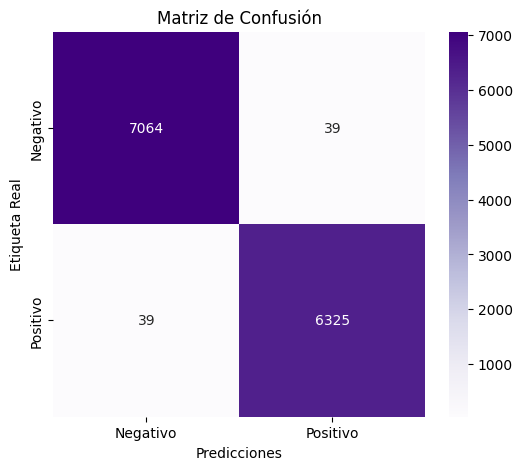

In [19]:
evaluacion(y_test, y_pred_best)

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)

In [21]:
roc_auc = auc(fpr, tpr)

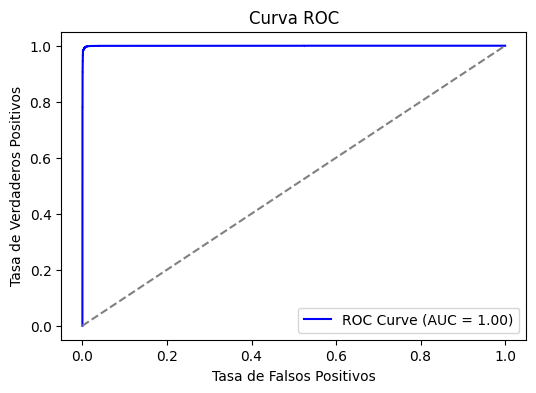

In [22]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()

In [29]:
n = 20
feature_importance = np.abs(best_model.coef_.toarray()).flatten()
top_features = np.argsort(feature_importance)[-n:]

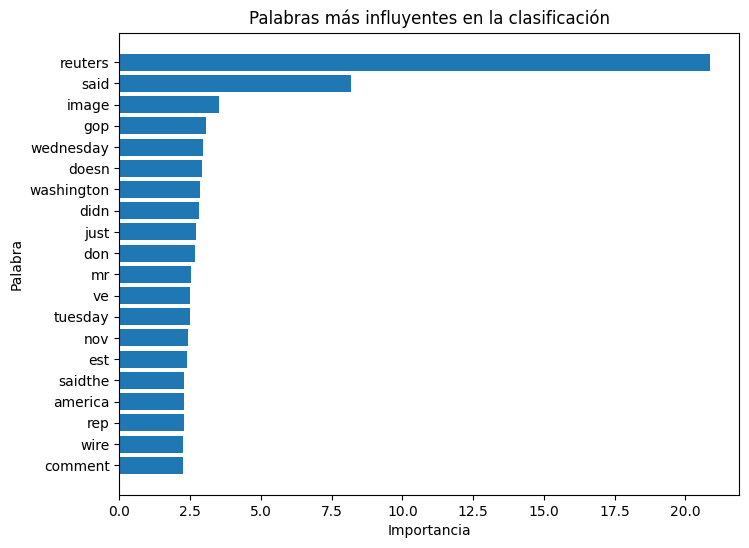

In [30]:
plt.figure(figsize=(8, 6))
plt.barh(np.array(vectorizer.get_feature_names_out())[top_features], feature_importance[top_features])
plt.xlabel("Importancia")
plt.ylabel("Palabra")
plt.title("Palabras más influyentes en la clasificación")
plt.show()

In [24]:
joblib.dump(best_model, "./modelo_svc/modelo_svc.pkl")
joblib.dump(vectorizer, "./modelo_svc/vectorizador_tfidf.pkl")

['./modelo_svc/vectorizador_tfidf.pkl']

In [33]:
params = best_model.get_params()
with open("./modelo_svc/params.json", "w") as f:
    json.dump(params, f)

In [35]:
resultados = {
    "y_pred_best": y_pred_best.tolist(),
    "y_prob_best": y_prob_best.tolist()
}
with open("./modelo_svc/resultados.json", "w") as f:
    json.dump(resultados, f)